### 1. Setup and Configuration
Imports libraries, defines file paths (updated for Ridge regression), and sets the time window for the full year of 2018.

In [23]:
from pathlib import Path
from typing import List, Tuple

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

import joblib

import requests
import holidays

# -------------------------
# Input
# -------------------------
DATA_PATH = Path("bike_data_clean.parquet")
CLUSTERS_TO_MODEL = [0, 8]

# -------------------------
# Output
# -------------------------
ART_DIR = Path("artifacts_ridge_daily")
PRED_DIR = Path("preds_ridge_daily")
ART_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# Time split (by predicted day d+1)
# -------------------------
VAL_START  = pd.to_datetime("2018-11-01")
VAL_END    = pd.to_datetime("2018-12-01")  # exclusive
TEST_START = pd.to_datetime("2018-12-01")  # Dec onward

# Full-year window
START_TIME = pd.Timestamp("2018-01-01 00:00:00")
END_TIME   = pd.Timestamp("2018-12-31 23:00:00")

# Weather data
NYC_LAT = 40.7128
NYC_LON = -74.0060
WEATHER_TZ = "America/New_York"

WEATHER_VARS = ["temperature_2m", "precipitation", "snowfall", "windspeed_10m"]
WEATHER_CACHE = ART_DIR / "weather_nyc_2018_hourly.parquet"

EPS = 1e-6

assert DATA_PATH.exists(), f"Missing {DATA_PATH}"
print("[OK] Config set.")
print("[INFO] Window:", START_TIME, "to", END_TIME)
print("[INFO] Val:", VAL_START, "to", VAL_END, "(exclusive)")
print("[INFO] Test from:", TEST_START)


[OK] Config set.
[INFO] Window: 2018-01-01 00:00:00 to 2018-12-31 23:00:00
[INFO] Val: 2018-11-01 00:00:00 to 2018-12-01 00:00:00 (exclusive)
[INFO] Test from: 2018-12-01 00:00:00


#### Fetching Weather Data from 2018 in NYC

In [24]:
def fetch_open_meteo_hourly(lat, lon, start="2018-01-01", end="2018-12-31", tz="America/New_York"):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "hourly": ",".join(WEATHER_VARS),
        "timezone": tz,
    }
    r = requests.get(url, params=params, timeout=120)
    r.raise_for_status()
    j = r.json()

    w = pd.DataFrame(j["hourly"])
    if "time" in w.columns:
        w["timestamp"] = pd.to_datetime(w["time"])
        w = w.drop(columns=["time"])
    elif "timestamp" in w.columns:
        w["timestamp"] = pd.to_datetime(w["timestamp"])
    else:
        raise ValueError(f"Unexpected weather payload columns: {list(w.columns)}")

    # Make timestamps naive to match your bike convention
    if getattr(w["timestamp"].dt, "tz", None) is not None:
        w["timestamp"] = w["timestamp"].dt.tz_localize(None)

    w["date"] = w["timestamp"].dt.normalize()
    w["hour"] = w["timestamp"].dt.hour.astype(int)

    keep = ["date", "hour"] + WEATHER_VARS
    missing = [c for c in keep if c not in w.columns]
    if missing:
        raise ValueError(f"Weather missing columns: {missing} (got {list(w.columns)})")

    w = w[keep].copy()
    for c in WEATHER_VARS:
        w[c] = w[c].astype("float32").fillna(0.0)

    return w


def load_weather_2018(force_refetch: bool = False):
    if WEATHER_CACHE.exists() and not force_refetch:
        w = pd.read_parquet(WEATHER_CACHE)

        # back-compat: rebuild date/hour if cache is old
        if "date" not in w.columns or "hour" not in w.columns:
            if "timestamp" in w.columns:
                w["timestamp"] = pd.to_datetime(w["timestamp"])
            elif "time" in w.columns:
                w["timestamp"] = pd.to_datetime(w["time"])
            else:
                return load_weather_2018(force_refetch=True)

            if getattr(w["timestamp"].dt, "tz", None) is not None:
                w["timestamp"] = w["timestamp"].dt.tz_localize(None)

            w["date"] = w["timestamp"].dt.normalize()
            w["hour"] = w["timestamp"].dt.hour.astype(int)

        need = set(["date", "hour"] + WEATHER_VARS)
        if not need.issubset(set(w.columns)):
            print("[WARN] Cached weather missing columns, refetching")
            return load_weather_2018(force_refetch=True)

        w["date"] = pd.to_datetime(w["date"]).dt.normalize()
        w["hour"] = w["hour"].astype(int)
        w = w[["date", "hour"] + WEATHER_VARS].copy()
        for c in WEATHER_VARS:
            w[c] = w[c].astype("float32").fillna(0.0)
        return w

    w = fetch_open_meteo_hourly(NYC_LAT, NYC_LON, "2018-01-01", "2018-12-31", WEATHER_TZ)
    w.to_parquet(WEATHER_CACHE, index=False)
    print("[OK] Saved weather cache ->", WEATHER_CACHE)
    return w


weather_hourly = load_weather_2018()
print("[INFO] weather_hourly:", weather_hourly.shape, weather_hourly["date"].min(), weather_hourly["date"].max())


[INFO] weather_hourly: (8760, 6) 2018-01-01 00:00:00 2018-12-31 00:00:00


### 2. Data Aggregation
Aggregates raw trip data into hourly time series (pickups and dropoffs) for the specified clusters.

In [25]:
def build_hourly_demand_for_cluster(df: pd.DataFrame, cluster_id: int) -> pd.DataFrame:
    df_pick = df[df["gmm20_cluster"] == cluster_id]
    df_drop = df[df["end_gmm20_cluster"] == cluster_id]

    if df_pick.empty and df_drop.empty:
        raise ValueError(f"No trip data for cluster {cluster_id}")

    pick_group = (
        df_pick.groupby(["start_date", "start_hour"])
        .size().rename("pickups").reset_index()
        .rename(columns={"start_date": "date", "start_hour": "hour"})
    )
    drop_group = (
        df_drop.groupby(["stop_date", "stop_hour"])
        .size().rename("dropoffs").reset_index()
        .rename(columns={"stop_date": "date", "stop_hour": "hour"})
    )

    pick_group["date"] = pd.to_datetime(pick_group["date"]).dt.normalize()
    drop_group["date"] = pd.to_datetime(drop_group["date"]).dt.normalize()

    min_date = START_TIME.normalize()
    max_date = END_TIME.normalize()

    pick_group = pick_group[(pick_group["date"] >= min_date) & (pick_group["date"] <= max_date)]
    drop_group = drop_group[(drop_group["date"] >= min_date) & (drop_group["date"] <= max_date)]

    all_dates = pd.date_range(min_date, max_date, freq="D")
    hours = np.arange(24)
    idx = pd.MultiIndex.from_product([all_dates, hours], names=["date", "hour"])
    hourly = pd.DataFrame(index=idx).reset_index()

    hourly = hourly.merge(pick_group, on=["date", "hour"], how="left")
    hourly = hourly.merge(drop_group, on=["date", "hour"], how="left")

    hourly["pickups"] = hourly["pickups"].fillna(0).astype("float32")
    hourly["dropoffs"] = hourly["dropoffs"].fillna(0).astype("float32")
    hourly["cluster_id"] = int(cluster_id)

    # Merge hourly realized weather (NYC)
    hourly = hourly.merge(weather_hourly, on=["date", "hour"], how="left")
    for c in WEATHER_VARS:
        hourly[c] = hourly[c].fillna(0.0).astype("float32")


    return hourly


### 3. Feature Engineering
Generates lag features (1h, 24h, 1 week) and rolling means to capture temporal dependencies.

In [26]:
def build_supervised_from_hourly(
    hourly_df: pd.DataFrame,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DatetimeIndex]:

    daily_p = hourly_df.pivot(index="date", columns="hour", values="pickups")
    daily_d = hourly_df.pivot(index="date", columns="hour", values="dropoffs")

    # Weather matrices (day × hour) for each variable
    daily_w = {v: hourly_df.pivot(index="date", columns="hour", values=v) for v in WEATHER_VARS}

    # Ensure all 24 hours exist
    for h in range(24):
        if h not in daily_p.columns:
            daily_p[h] = 0.0
        if h not in daily_d.columns:
            daily_d[h] = 0.0
        for v in WEATHER_VARS:
            if h not in daily_w[v].columns:
                daily_w[v][h] = 0.0

    daily_p = daily_p[sorted(daily_p.columns)]
    daily_d = daily_d[sorted(daily_d.columns)]
    for v in WEATHER_VARS:
        daily_w[v] = daily_w[v][sorted(daily_w[v].columns)].fillna(0.0)

    # Sort by date (common index)
    dates = daily_p.index.sort_values()
    daily_p = daily_p.loc[dates]
    daily_d = daily_d.loc[dates]
    for v in WEATHER_VARS:
        daily_w[v] = daily_w[v].loc[dates]

    # Holidays (US-NY)
    years = sorted(pd.to_datetime(dates).year.unique().tolist())
    try:
        hcal = holidays.country_holidays("US", subdiv="NY", years=years)
    except Exception:
        hcal = holidays.country_holidays("US", years=years)

    X_list, Yp_list, Yd_list, pred_dates = [], [], [], []

    for i in range(7, len(dates) - 1):
        d = dates[i]
        d_next = dates[i + 1]
        d_last_week = dates[i - 6]

        is_weekend = 1.0 if d_next.weekday() >= 5 else 0.0

        # holiday flags for target day d+1
        is_holiday = 1.0 if d_next.date() in hcal else 0.0
        is_before_holiday = 1.0 if (d_next + pd.Timedelta(days=1)).date() in hcal else 0.0
        is_after_holiday  = 1.0 if (d_next - pd.Timedelta(days=1)).date() in hcal else 0.0

        # realized weather for target day d+1: concat 24h per variable
        weather_next = np.concatenate(
            [daily_w[v].loc[d_next].values.astype("float32") for v in WEATHER_VARS]
        )

        X_vec = np.concatenate(
            [
                daily_p.loc[d].values.astype("float32"),
                daily_d.loc[d].values.astype("float32"),
                daily_p.loc[d_last_week].values.astype("float32"),
                daily_d.loc[d_last_week].values.astype("float32"),
                weather_next,  # 24*len(WEATHER_VARS)
                np.array([is_holiday, is_before_holiday, is_after_holiday], dtype="float32"),
                np.array([d_next.weekday(), is_weekend, d_next.month], dtype="float32"),
            ]
        )

        y_pick = daily_p.loc[d_next].values.astype("float32")
        y_drop = daily_d.loc[d_next].values.astype("float32")

        X_list.append(X_vec)
        Yp_list.append(y_pick)
        Yd_list.append(y_drop)
        pred_dates.append(d_next)

    X = np.stack(X_list)
    Yp = np.stack(Yp_list)
    Yd = np.stack(Yd_list)
    pred_dates = pd.to_datetime(pred_dates)

    return X, Yp, Yd, pred_dates


### 4. Data Splitting
Splits the time series data into Train (Jan-Oct), Validation (Nov), and Test (Dec) sets.

In [27]:
def split_train_val_test(X, Yp, Yd, pred_dates):
    train_mask = pred_dates < VAL_START
    val_mask   = (pred_dates >= VAL_START) & (pred_dates < TEST_START)
    test_mask  = pred_dates >= TEST_START

    return (
        X[train_mask], X[val_mask], X[test_mask],
        Yp[train_mask], Yp[val_mask], Yp[test_mask],
        Yd[train_mask], Yd[val_mask], Yd[test_mask],
        pred_dates[train_mask], pred_dates[val_mask], pred_dates[test_mask]
    )


### 5. Model Architecture
Defines the Ridge Regression pipeline, utilizing One-Hot Encoding for categorical features and passing through numeric features.

In [28]:
def make_ridge():
    # Multi-output Ridge happens automatically when y is (n_samples, 24)
    return Ridge(alpha=1.0, fit_intercept=True, solver="auto")

def fit_ridge_multi(X_train: np.ndarray, Y_train: np.ndarray):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train)

    model = make_ridge()
    model.fit(Xtr, Y_train)  # Y_train: (n_days, 24)
    return scaler, model

def predict_ridge_multi(scaler, model, X: np.ndarray) -> np.ndarray:
    if X.size == 0:
        return np.zeros((0, 24), dtype="float32")
    Xs = scaler.transform(X)
    pred = model.predict(Xs).astype("float32")
    return np.clip(pred, 0.0, None)


### 6. Output Formatting
Helper function to merge model predictions with ground truth data, ensuring consistent column naming for the Ridge model.

In [29]:
def to_output_df_daily(
    cluster_id: int,
    split_name: str,
    dates_split: pd.DatetimeIndex,
    Yp_true: np.ndarray,
    Yp_pred: np.ndarray,
    Yd_true: np.ndarray,
    Yd_pred: np.ndarray,
) -> pd.DataFrame:
    rows = []
    for i, d in enumerate(dates_split):
        date_norm = pd.Timestamp(d).normalize()
        for h in range(24):
            rows.append({
                "date": date_norm,
                "hour": int(h),
                "cluster_id": int(cluster_id),
                "split": split_name,
                "y_true_pickups": float(Yp_true[i, h]),
                "y_pred_ridge_pickups": float(Yp_pred[i, h]),
                "y_true_dropoffs": float(Yd_true[i, h]),
                "y_pred_ridge_dropoffs": float(Yd_pred[i, h]),
            })
    return pd.DataFrame(rows, columns=[
        "date","hour","cluster_id","split",
        "y_true_pickups","y_pred_ridge_pickups",
        "y_true_dropoffs","y_pred_ridge_dropoffs",
    ])


### 7. Training and Execution Loop
Iterates through each cluster to train Ridge models for pickups and dropoffs, saving predictions and artifacts.

In [19]:
needed_cols = ["gmm20_cluster","end_gmm20_cluster","start_date","start_hour","stop_date","stop_hour"]
df = pd.read_parquet(DATA_PATH, columns=needed_cols)
print("[INFO] Loaded df:", df.shape)

clusters_set = set(CLUSTERS_TO_MODEL)
mask = df["gmm20_cluster"].isin(clusters_set) | df["end_gmm20_cluster"].isin(clusters_set)
df = df.loc[mask].copy()
print("[INFO] Filtered df:", df.shape)

all_out_rows = []

for cid in CLUSTERS_TO_MODEL:
    print("\n" + "="*80)
    print(f"[CLUSTER {cid}] training DAILY multi-output Ridge...")

    hourly = build_hourly_demand_for_cluster(df, cid)
    X, Yp, Yd, pred_dates = build_supervised_from_hourly(hourly)

    (
        X_train, X_val, X_test,
        Yp_train, Yp_val, Yp_test,
        Yd_train, Yd_val, Yd_test,
        dates_train, dates_val, dates_test
    ) = split_train_val_test(X, Yp, Yd, pred_dates)

    print(f"[CLUSTER {cid}] train/val/test days = {len(dates_train)}/{len(dates_val)}/{len(dates_test)}")

    # Fit one ridge per target type (pickups / dropoffs), both multi-output(24)
    scaler_p, model_p = fit_ridge_multi(X_train, Yp_train)
    scaler_d, model_d = fit_ridge_multi(X_train, Yd_train)

    Yp_pred_val  = predict_ridge_multi(scaler_p, model_p, X_val)
    Yd_pred_val  = predict_ridge_multi(scaler_d, model_d, X_val)

    Yp_pred_test = predict_ridge_multi(scaler_p, model_p, X_test)
    Yd_pred_test = predict_ridge_multi(scaler_d, model_d, X_test)

    df_val_out = to_output_df_daily(cid, "val", dates_val, Yp_val, Yp_pred_val, Yd_val, Yd_pred_val)
    all_out_rows.append(df_val_out)

    if len(dates_test):
        df_test_out = to_output_df_daily(cid, "test", dates_test, Yp_test, Yp_pred_test, Yd_test, Yd_pred_test)
        all_out_rows.append(df_test_out)
        df_out = pd.concat([df_val_out, df_test_out], ignore_index=True)
    else:
        df_out = df_val_out.copy()

    out_path = PRED_DIR / f"ridge_cluster_{cid}_preds.parquet"
    df_out.to_parquet(out_path, index=False)
    print(f"[CLUSTER {cid}] saved predictions -> {out_path}")

    artifact = {
        "cluster_id": int(cid),
        "scaler_pickups": scaler_p,
        "model_pickups": model_p,
        "scaler_dropoffs": scaler_d,
        "model_dropoffs": model_d,
        "split_info": {
            "start_time": str(START_TIME),
            "val_start": str(VAL_START),
            "val_end_exclusive": str(VAL_END),
            "test_start": str(TEST_START),
            "end_time": str(END_TIME),
        }
    }
    art_path = ART_DIR / f"ridge_cluster_{cid}.joblib"
    joblib.dump(artifact, art_path)
    print(f"[CLUSTER {cid}] saved artifact -> {art_path}")

print("\n[OK] Finished all clusters.")


[INFO] Loaded df: (17531179, 6)
[INFO] Filtered df: (3971074, 6)

[CLUSTER 0] training DAILY multi-output Ridge...
[CLUSTER 0] train/val/test days = 296/30/31
[CLUSTER 0] saved predictions -> preds_ridge_daily/ridge_cluster_0_preds.parquet
[CLUSTER 0] saved artifact -> artifacts_ridge_daily/ridge_cluster_0.joblib

[CLUSTER 8] training DAILY multi-output Ridge...
[CLUSTER 8] train/val/test days = 296/30/31
[CLUSTER 8] saved predictions -> preds_ridge_daily/ridge_cluster_8_preds.parquet
[CLUSTER 8] saved artifact -> artifacts_ridge_daily/ridge_cluster_8.joblib

[OK] Finished all clusters.


### 8. Global Evaluation and Weighting
Calculates the RMSE for the test period (December) and computes the ensemble weight for the Ridge model.

In [20]:
out_all = pd.concat(all_out_rows, ignore_index=True)

test_all = out_all[out_all["split"] == "test"].copy()
assert len(test_all), "No test rows found (expected December). Check END_TIME / TEST_START."

rmse_pick_test = float(np.sqrt(mean_squared_error(test_all["y_true_pickups"], test_all["y_pred_ridge_pickups"])))
rmse_drop_test = float(np.sqrt(mean_squared_error(test_all["y_true_dropoffs"], test_all["y_pred_ridge_dropoffs"])))
rmse_mean_test = 0.5 * (rmse_pick_test + rmse_drop_test)

# Baseline lag_24 in the output space (per cluster)
test_all_sorted = test_all.sort_values(["cluster_id", "date", "hour"]).copy()
test_all_sorted["baseline_pick"] = test_all_sorted.groupby("cluster_id")["y_true_pickups"].shift(24)
test_all_sorted["baseline_drop"] = test_all_sorted.groupby("cluster_id")["y_true_dropoffs"].shift(24)
base_ok = test_all_sorted.dropna(subset=["baseline_pick","baseline_drop"])

rmse_pick_base = float(np.sqrt(mean_squared_error(base_ok["y_true_pickups"], base_ok["baseline_pick"])))
rmse_drop_base = float(np.sqrt(mean_squared_error(base_ok["y_true_dropoffs"], base_ok["baseline_drop"])))
rmse_mean_base = 0.5 * (rmse_pick_base + rmse_drop_base)

general_weight_raw = 1.0 / (rmse_mean_test + EPS)

weight_payload = {
    "model": "ridge_hourly_ridge_features_simple",
    "clusters": CLUSTERS_TO_MODEL,
    "test_period": {"start_inclusive": str(TEST_START.date()), "end_inclusive": str(END_TIME.date())},
    "rmse_pickups_test": rmse_pick_test,
    "rmse_dropoffs_test": rmse_drop_test,
    "general_rmse_test": rmse_mean_test,
    "rmse_pickups_baseline_lag24_test": rmse_pick_base,
    "rmse_dropoffs_baseline_lag24_test": rmse_drop_base,
    "general_rmse_baseline_lag24_test": rmse_mean_base,
    "general_weight_raw": general_weight_raw,
    "notes": "Ridge regression on raw counts (with OHE+numeric features). Test RMSE is December."
}

weight_path = ART_DIR / "ridge_general_weight_test_december.json"
weight_path.write_text(json.dumps(weight_payload, indent=2))
print("[OK] Saved:", weight_path)
print(json.dumps(weight_payload, indent=2))

[OK] Saved: artifacts_ridge_daily/ridge_general_weight_test_december.json
{
  "model": "ridge_hourly_ridge_features_simple",
  "clusters": [
    0,
    8
  ],
  "test_period": {
    "start_inclusive": "2018-12-01",
    "end_inclusive": "2018-12-31"
  },
  "rmse_pickups_test": 90.88047384830713,
  "rmse_dropoffs_test": 98.2640632715999,
  "general_rmse_test": 94.57226855995351,
  "rmse_pickups_baseline_lag24_test": 89.45201615639775,
  "rmse_dropoffs_baseline_lag24_test": 84.08860241171544,
  "general_rmse_baseline_lag24_test": 86.7703092840566,
  "general_weight_raw": 0.010573924096915705,
  "notes": "Ridge regression on raw counts (with OHE+numeric features). Test RMSE is December."
}


### 9. Analysis Helper Functions
Utilities for loading cluster outputs and calculating the "Required Bikes" metric based on net flow.

In [21]:
def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def load_all_cluster_outputs(clusters, pred_dir: Path):
    dfs = []
    for cid in clusters:
        p = pred_dir / f"ridge_cluster_{cid}_preds.parquet"
        dfs.append(pd.read_parquet(p))
    out = pd.concat(dfs, ignore_index=True)
    out["timestamp"] = pd.to_datetime(out["date"]) + pd.to_timedelta(out["hour"], unit="h")
    out["month"] = out["timestamp"].dt.to_period("M").astype(str)
    return out

def compute_required_bikes_series(Yp: np.ndarray, Yd: np.ndarray) -> np.ndarray:
    required = []
    for pickups, dropoffs in zip(Yp, Yd):
        net = dropoffs - pickups
        cum_net = np.cumsum(net)
        min_cum = float(cum_net.min())
        req = max(0.0, -min_cum)
        required.append(req)
    return np.array(required, dtype="float32")

def daily_required_from_hourly_df(df_hourly: pd.DataFrame, true_col_p, true_col_d, pred_col_p, pred_col_d):
    dfh = df_hourly.copy()
    dfh["day"] = dfh["timestamp"].dt.normalize()

    days = []
    for day, g in dfh.groupby("day"):
        g = g.sort_values("hour")
        if len(g) < 24:
            continue
        Yp_true = g[true_col_p].values.reshape(1, -1)
        Yd_true = g[true_col_d].values.reshape(1, -1)
        Yp_pred = g[pred_col_p].values.reshape(1, -1)
        Yd_pred = g[pred_col_d].values.reshape(1, -1)

        req_true = compute_required_bikes_series(Yp_true, Yd_true)[0]
        req_pred = compute_required_bikes_series(Yp_pred, Yd_pred)[0]
        days.append((day, req_true, req_pred))

    return pd.DataFrame(days, columns=["day", "required_true", "required_pred"])

### 10. Performance Dashboard
Visualizes Ridge model performance, including weekly predictions, required bike estimates, and daily RMSE metrics.

/tmp/ipykernel_160462/3110034374.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


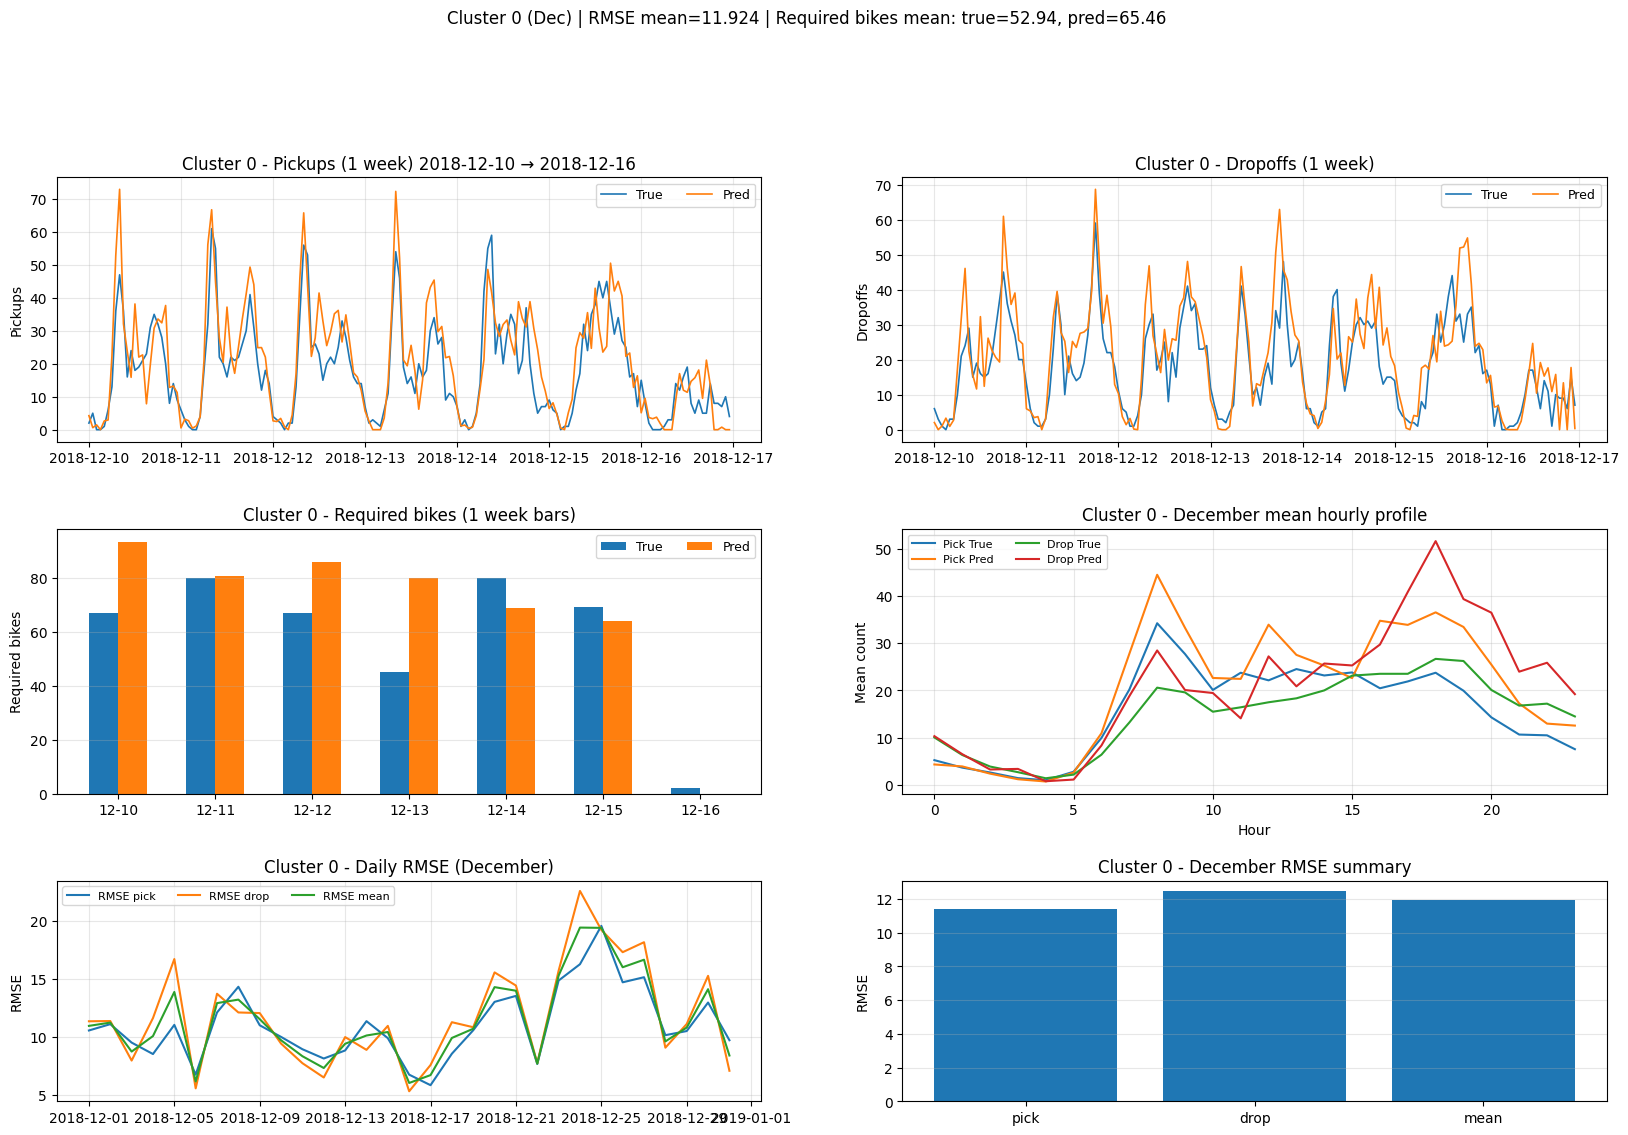

/tmp/ipykernel_160462/3110034374.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


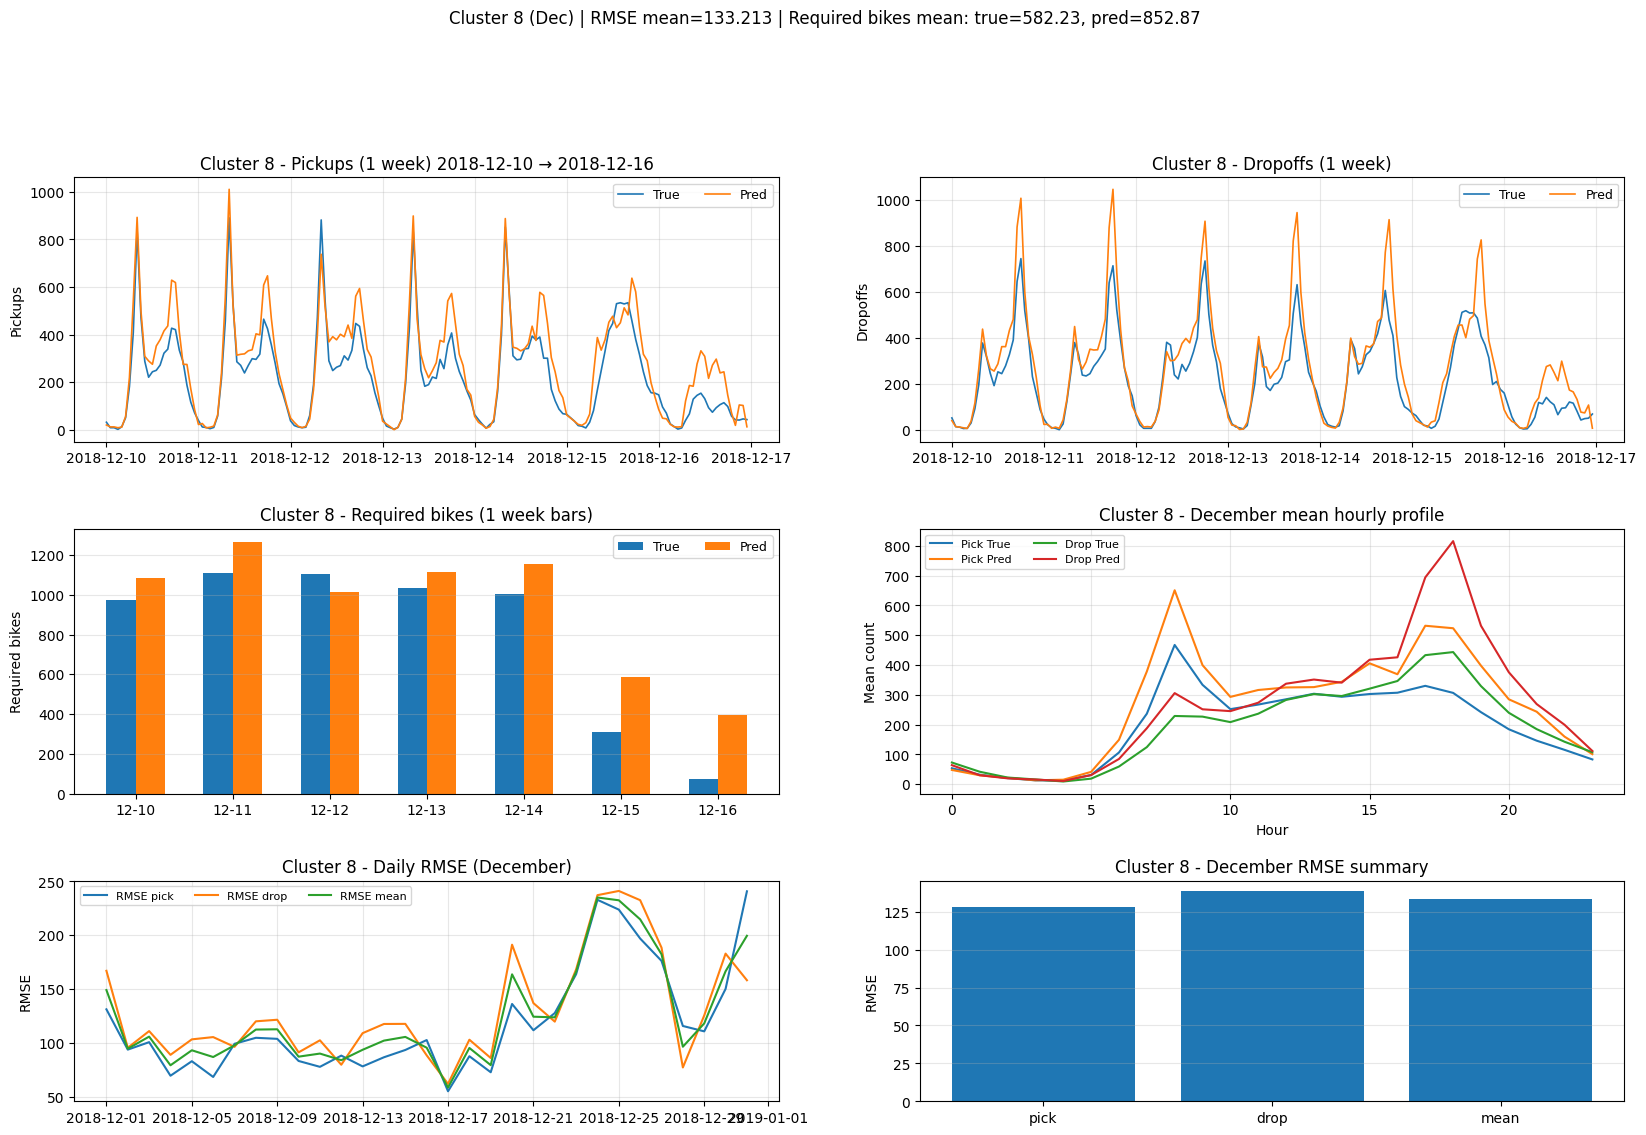

In [22]:
out_all = load_all_cluster_outputs(CLUSTERS_TO_MODEL, PRED_DIR)

DEC_START = pd.Timestamp("2018-12-01")
DEC_END   = pd.Timestamp("2018-12-31 23:00:00")

WEEK_START = pd.Timestamp("2018-12-10 00:00:00")
WEEK_END   = WEEK_START + pd.Timedelta(days=7)  # exclusive

TRUE_P = "y_true_pickups"
PRED_P = "y_pred_ridge_pickups"
TRUE_D = "y_true_dropoffs"
PRED_D = "y_pred_ridge_dropoffs"

for cid in CLUSTERS_TO_MODEL:
    dfc = out_all[(out_all["cluster_id"] == cid) & (out_all["split"] == "test")].copy()
    dfc = dfc[(dfc["timestamp"] >= DEC_START) & (dfc["timestamp"] <= DEC_END)]
    dfc = dfc.sort_values("timestamp")

    if dfc.empty:
        print(f"[WARN] No December test data for cluster {cid}")
        continue

    week = dfc[(dfc["timestamp"] >= WEEK_START) & (dfc["timestamp"] < WEEK_END)].copy()

    mean_hour = (
        dfc.groupby("hour")[[TRUE_P, PRED_P, TRUE_D, PRED_D]]
        .mean()
        .reset_index()
        .sort_values("hour")
    )

    req_daily = daily_required_from_hourly_df(dfc, TRUE_P, TRUE_D, PRED_P, PRED_D)
    mean_req = req_daily[["required_true", "required_pred"]].mean()

    dfc["day"] = dfc["timestamp"].dt.normalize()
    daily_metrics = []
    for day, g in dfc.groupby("day"):
        g = g.sort_values("hour")
        if len(g) < 24:
            continue
        rp = rmse(g[TRUE_P].values, g[PRED_P].values)
        rd = rmse(g[TRUE_D].values, g[PRED_D].values)
        daily_metrics.append((day, rp, rd, 0.5*(rp+rd)))
    daily_metrics = pd.DataFrame(daily_metrics, columns=["day", "rmse_pickups", "rmse_dropoffs", "rmse_mean"])

    rmse_pick = rmse(dfc[TRUE_P].values, dfc[PRED_P].values)
    rmse_drop = rmse(dfc[TRUE_D].values, dfc[PRED_D].values)
    rmse_avg  = 0.5*(rmse_pick + rmse_drop)

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.2, 1.0], hspace=0.35, wspace=0.2)

    # (1) One-week pickups
    ax = fig.add_subplot(gs[0, 0])
    if not week.empty:
        ax.plot(week["timestamp"], week[TRUE_P], label="True", linewidth=1.2)
        ax.plot(week["timestamp"], week[PRED_P], label="Pred", linewidth=1.2)
        ax.set_title(f"Cluster {cid} - Pickups (1 week) {WEEK_START.date()} → {(WEEK_END - pd.Timedelta(hours=1)).date()}")
        ax.set_ylabel("Pickups")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize=9)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (2) One-week dropoffs
    ax = fig.add_subplot(gs[0, 1])
    if not week.empty:
        ax.plot(week["timestamp"], week[TRUE_D], label="True", linewidth=1.2)
        ax.plot(week["timestamp"], week[PRED_D], label="Pred", linewidth=1.2)
        ax.set_title(f"Cluster {cid} - Dropoffs (1 week)")
        ax.set_ylabel("Dropoffs")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=2, fontsize=9)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (3) Required bikes bars (first 7 days of the week)
    ax = fig.add_subplot(gs[1, 0])
    if not week.empty:
        req_week = daily_required_from_hourly_df(week, TRUE_P, TRUE_D, PRED_P, PRED_D)
        req_week = req_week.sort_values("day").head(7)
        x = np.arange(len(req_week))
        ax.bar(x - 0.15, req_week["required_true"].values, width=0.3, label="True")
        ax.bar(x + 0.15, req_week["required_pred"].values, width=0.3, label="Pred")
        ax.set_xticks(x)
        ax.set_xticklabels(req_week["day"].dt.strftime("%m-%d").values, rotation=0)
        ax.set_title(f"Cluster {cid} - Required bikes (1 week bars)")
        ax.set_ylabel("Required bikes")
        ax.legend(ncol=2, fontsize=9)
        ax.grid(True, axis="y", alpha=0.3)
    else:
        ax.text(0.5, 0.5, "Week window empty", ha="center", va="center")
        ax.set_axis_off()

    # (4) December mean hourly profile
    ax = fig.add_subplot(gs[1, 1])
    ax.plot(mean_hour["hour"], mean_hour[TRUE_P], label="Pick True")
    ax.plot(mean_hour["hour"], mean_hour[PRED_P], label="Pick Pred")
    ax.plot(mean_hour["hour"], mean_hour[TRUE_D], label="Drop True")
    ax.plot(mean_hour["hour"], mean_hour[PRED_D], label="Drop Pred")
    ax.set_title(f"Cluster {cid} - December mean hourly profile")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Mean count")
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=8)

    # (5) Daily RMSE line
    ax = fig.add_subplot(gs[2, 0])
    if not daily_metrics.empty:
        ax.plot(daily_metrics["day"], daily_metrics["rmse_pickups"], label="RMSE pick")
        ax.plot(daily_metrics["day"], daily_metrics["rmse_dropoffs"], label="RMSE drop")
        ax.plot(daily_metrics["day"], daily_metrics["rmse_mean"], label="RMSE mean")
        ax.set_title(f"Cluster {cid} - Daily RMSE (December)")
        ax.set_ylabel("RMSE")
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=3, fontsize=8)
    else:
        ax.text(0.5, 0.5, "No daily metrics", ha="center", va="center")
        ax.set_axis_off()

    # (6) RMSE summary bars
    ax = fig.add_subplot(gs[2, 1])
    ax.bar(["pick", "drop", "mean"], [rmse_pick, rmse_drop, rmse_avg])
    ax.set_title(f"Cluster {cid} - December RMSE summary")
    ax.set_ylabel("RMSE")
    ax.grid(True, axis="y", alpha=0.3)

    fig.suptitle(
        f"Cluster {cid} (Dec) | RMSE mean={rmse_avg:.3f} | Required bikes mean: true={mean_req['required_true']:.2f}, pred={mean_req['required_pred']:.2f}",
        y=1.02,
        fontsize=12
    )

    plt.tight_layout()
    plt.show()